In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_excel('/content/Data form Chlorhexidine Trial project.xlsx')

In [3]:
df.head()

,Trial Arm,Age,Gender,Outcome of the current episode,Outcome of current episode 2,APACHE II Score,TLC Day 1,TLC Day 2,TLC Day 3,TLC Day 4,...,Ulcer Day 2,Ulcer Day 3,Ulcer Day 4,Ulcer Day 5,Ulcer Day 6,Ulcer Day 7,Ulcer Day 8,Ulcer Day 9,Ulcer Day 10,Day 1
0,Group 1,49,Male,No VAP,Discharged,11.0,11900.0,12600.0,10900.0,10400.0,...,Negative,Negative,Negative,Negative,NaN,NaN,NaN,NaN,NaN,NaN
1,Group 1,72,Male,No VAP,Discharged,17.0,16800.0,17800.0,12400.0,9300.0,...,Negative,Negative,Negative,Negative,Negative,NaN,NaN,NaN,NaN,NaN
2,Group 1,72,Male,No VAP,Death,16.0,23300.0,46600.0,39200.0,27800.0,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,NaN,NaN,NaN
3,Group 1,55,Female,No VAP,Discharged,29.0,9500.0,9500.0,9400.0,11400.0,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,NaN
4,Group 1,20,Male,No VAP,LAMA,18.0,7000.0,10900.0,11800.0,7400.0,...,Negative,Negative,Negative,Negative,Negative,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(106, 85)

In [5]:
print("\nMissing values before cleaning:")
print(df.isnull().sum())



Missing values before cleaning:
Trial Arm                           0
Age                                 0
Gender                              0
Outcome of the current episode      7
Outcome of current episode 2        0
                                 ... 
Ulcer Day 7                        74
Ulcer Day 8                        83
Ulcer Day 9                        90
Ulcer Day 10                       92
Day 1                             106
Length: 85, dtype: int64


In [6]:
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing values after cleaning:")
print(df.isnull().sum())



Missing values after cleaning:
Trial Arm                           0
Age                                 0
Gender                              0
Outcome of the current episode      0
Outcome of current episode 2        0
                                 ... 
Ulcer Day 7                         0
Ulcer Day 8                         0
Ulcer Day 9                         0
Ulcer Day 10                        0
Day 1                             106
Length: 85, dtype: int64


/tmp/ipython-input-3237426579.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-3237426579.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [7]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = df.select_dtypes(include=['object']).columns

label_encoders = {}
for col in categorical_cols:
    # Convert column to string type to ensure uniformity before encoding
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("\nCategorical variables encoded successfully.")


Categorical variables encoded successfully.


In [33]:
duration_col = "time_to_event"
event_col = "event"

df['duration'] = df[duration_col]
df['event_observed'] = df[event_col]

print("\nSurvival objects created:")
print(df[['duration', 'event_observed']].head())


Survival objects created:
   duration  event_observed
0        10               0
1        10               0
2        10               0
3        10               0
4        10               0


In [25]:
# Define CPIS columns (assuming CPIS Day 1 to CPIS Day 10 exist)
cpis_cols = [f"CPIS Day {i}" for i in range(1, 11)]

# Ensure CPIS columns are numeric, coercing errors
for col in cpis_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    else:
        print(f"WARNING: {col} not found in columns! It will be treated as all NaN.")

time_list = []
event_list = []

print("\nComputing time_to_event and event based on CPIS scores...")

for idx, row in df.iterrows():
    event_day = None

    # Loop through CPIS Day 1 to Day 10 to find VAP event
    for day_index, col in enumerate(cpis_cols, start=1):
        value = row.get(col, np.nan)

        if pd.notna(value) and value >= 6:
            event_day = day_index
            break  # VAP occurred, record the day and break

    if event_day is not None:
        # VAP occurred
        time_list.append(event_day)
        event_list.append(1)
    else:
        # No VAP: censor at last observed CPIS day
        # Find the last day with a non-NaN CPIS value
        valid_days = [
            day_index for day_index, col in enumerate(cpis_cols, start=1)
            if pd.notna(row.get(col, np.nan))
        ]

        if len(valid_days) > 0:
            last_day = max(valid_days)
        else:
            # If all CPIS are missing, assume censoring at day 1 (conservative)
            last_day = 1

        time_list.append(last_day)
        event_list.append(0)

# Add these as new columns to the DataFrame
df["time_to_event"] = time_list
df["event"] = event_list

print("\n'time_to_event' and 'event' columns created successfully.")
print("Value counts for event (0=censored, 1=VAP):")
print(df["event"].value_counts().to_markdown(numalign="left", stralign="left"))
print("\nFirst 5 rows with new columns:")
print(df[['time_to_event', 'event']].head().to_markdown(index=False, numalign="left", stralign="left"))


Computing time_to_event and event based on CPIS scores...

'time_to_event' and 'event' columns created successfully.
Value counts for event (0=censored, 1=VAP):
| event   | count   |
|:--------|:--------|
| 0       | 98      |
| 1       | 8       |

First 5 rows with new columns:
| time_to_event   | event   |
|:----------------|:--------|
| 10              | 0       |
| 10              | 0       |
| 10              | 0       |
| 10              | 0       |
| 10              | 0       |


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


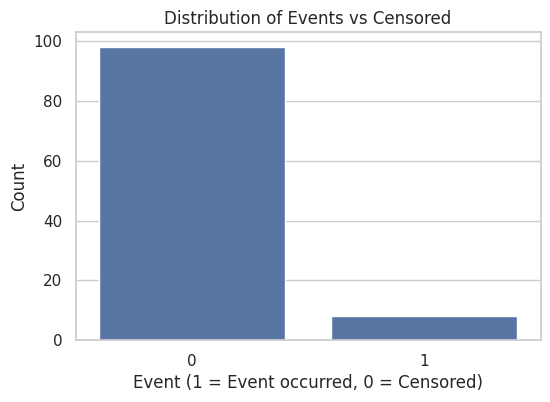

In [34]:
# 1. EVENT VS CENSORED DISTRIBUTION
plt.figure(figsize=(6,4))
sns.countplot(x=df['event_observed'])
plt.title("Distribution of Events vs Censored")
plt.xlabel("Event (1 = Event occurred, 0 = Censored)")
plt.ylabel("Count")
plt.show()

In [17]:
# 2. SUMMARY STATISTICS
print("\nSummary Statistics:")
print(df.describe())



Summary Statistics:
        Trial Arm         Age      Gender  Outcome of the current episode  \
count  106.000000  106.000000  106.000000                      106.000000   
mean     0.424528   47.594340    0.877358                        0.066038   
std      0.496619   17.319286    0.329584                        0.249528   
min      0.000000   18.000000    0.000000                        0.000000   
25%      0.000000   32.000000    1.000000                        0.000000   
50%      0.000000   50.000000    1.000000                        0.000000   
75%      1.000000   62.000000    1.000000                        0.000000   
max      1.000000   75.000000    1.000000                        1.000000   

       Outcome of current episode 2  APACHE II Score     TLC Day 1  \
count                    106.000000       106.000000    106.000000   
mean                       2.188679        17.037736  15216.037736   
std                        1.015248         6.620206   7269.677884   
min  

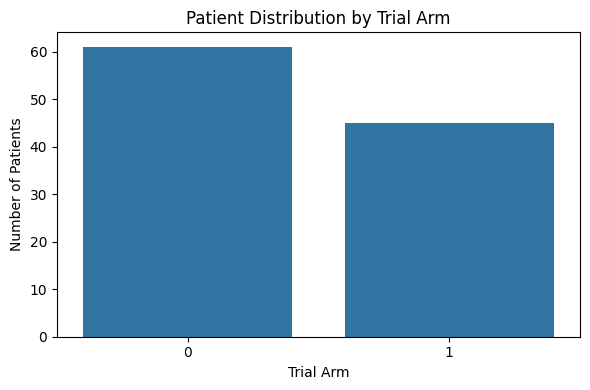

In [18]:
# trial arm distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="Trial Arm", data=df)
plt.title("Patient Distribution by Trial Arm")
plt.xlabel("Trial Arm")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.savefig("trial_arm_distribution.png", dpi=300)
plt.show()

<Figure size 600x400 with 0 Axes>

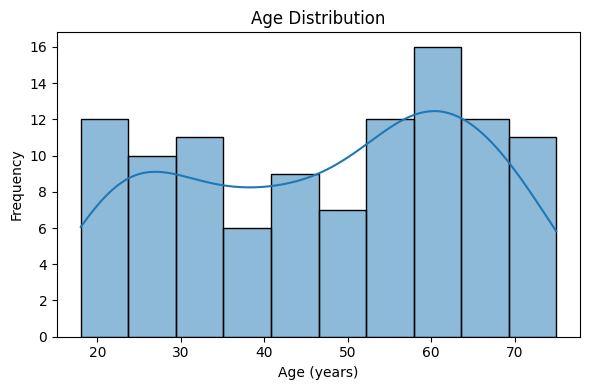

In [19]:
#age histo gram
plt.figure(figsize=(6, 4))
plt.figure(figsize=(6, 4))
sns.histplot(df["Age"].dropna(), bins=10, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age (years)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

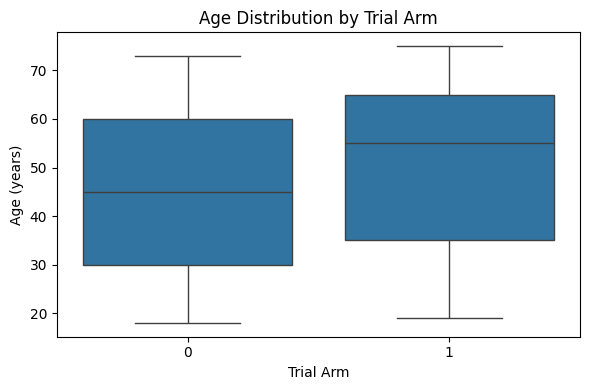

In [20]:
# age distribution by trial arm
plt.figure(figsize=(6, 4))
sns.boxplot(x="Trial Arm", y="Age", data=df)
plt.title("Age Distribution by Trial Arm")
plt.xlabel("Trial Arm")
plt.ylabel("Age (years)")
plt.tight_layout()
plt.show()

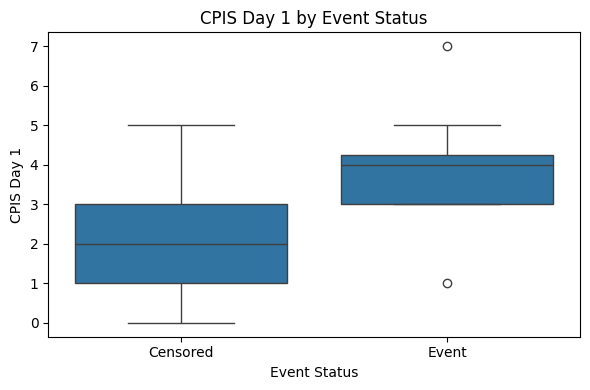

In [21]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["event"].map({0: "Censored", 1: "Event"}),
                y=df["CPIS Day 1"])
plt.title("CPIS Day 1 by Event Status")
plt.xlabel("Event Status")
plt.ylabel("CPIS Day 1")
plt.tight_layout()
plt.show()

In [22]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 10.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=bfabd156a9e02a29af6afd2ae7a9ae00b969ea3f06636d1696d2889a190e9e2d
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import survival_table_from_events
sns.set(style="whitegrid")



Fitting Kaplan–Meier curves...


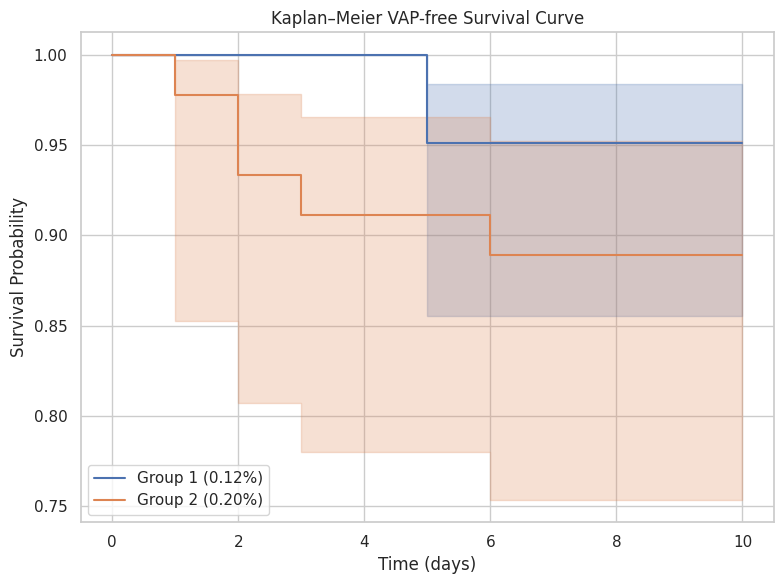

In [27]:
#k-m estimator
print("\nFitting Kaplan–Meier curves...")

km = KaplanMeierFitter()

plt.figure(figsize=(8, 6))

# KM curve for Group 1 (0.12% chlorhexidine)
mask_g1 = df["trial_arm_binary"] == 0
km.fit(durations=df.loc[mask_g1, "time_to_event"],
       event_observed=df.loc[mask_g1, "event"],
       label="Group 1 (0.12%)")
ax = km.plot(ci_show=True)

# KM curve for Group 2 (0.2% chlorhexidine)
mask_g2 = df["trial_arm_binary"] == 1
km.fit(durations=df.loc[mask_g2, "time_to_event"],
       event_observed=df.loc[mask_g2, "event"],
       label="Group 2 (0.20%)")
km.plot(ax=ax, ci_show=True)

plt.title("Kaplan–Meier VAP-free Survival Curve")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.tight_layout()
plt.savefig("km_curve.png", dpi=300)
plt.show()

In [26]:

if "Trial Arm" in df.columns:

    df["trial_arm_binary"] = df["Trial Arm"].map(
        lambda x: 1 if x == 1 else 0 # Assuming 1 is Group 2, and 0 is Group 1 after encoding
    )
else:
    print("WARNING: 'Trial Arm' column not found!")

print("\n'trial_arm_binary' column created/confirmed successfully.")
print(df[['Trial Arm', 'trial_arm_binary']].head())


'trial_arm_binary' column created/confirmed successfully.
   Trial Arm  trial_arm_binary
0          0                 0
1          0                 0
2          0                 0
3          0                 0
4          0                 0


In [28]:
#life table
print("\nGenerating life table...")

life_table = survival_table_from_events(
    df["time_to_event"],
    df["event"]
)

print("\nLife Table (Overall):")
print(life_table)


Generating life table...

Life Table (Overall):
          removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0       106      106
1.0             1         1         0         0      106
2.0             2         2         0         0      105
3.0             1         1         0         0      103
5.0             3         3         0         0      102
6.0             1         1         0         0       99
10.0           98         0        98         0       98


In [29]:
#Log-Rank test
print("\nRunning log-rank test between Group 1 and Group 2...")

results = logrank_test(
    df.loc[mask_g1, "time_to_event"], df.loc[mask_g2, "time_to_event"],
    df.loc[mask_g1, "event"], df.loc[mask_g2, "event"]
)

print("\nLog-rank test result:")
print(results.summary)

with open("logrank_test.txt", "w") as f:
    f.write(str(results.summary))

print("✔ Log-rank test saved: logrank_test.txt")


Running log-rank test between Group 1 and Group 2...

Log-rank test result:
   test_statistic         p  -log2(p)
0        1.524198  0.216985  2.204331
✔ Log-rank test saved: logrank_test.txt



Fitting Cox PH model...

Cox Model Summary:
                      coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                         
trial_arm_binary  1.014728   2.758612  0.748586       -0.452474   
Age               0.007895   1.007926  0.021430       -0.034108   
APACHE II Score  -0.073426   0.929205  0.063530       -0.197943   

                  coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                    
trial_arm_binary        2.481929             0.636052            11.964327   
Age                     0.049898             0.966467             1.051163   
APACHE II Score         0.051091             0.820417             1.052418   

                  cmp to         z         p  -log2(p)  
covariate                                               
trial_arm_binary     0.0  1.355525  0.175250  2.512512  
Age                  0.0  0.368393  0.712580  0.488876  


<lifelines.CoxPHFitter: fitted with 106 total observations, 98 right-censored observations>
             duration col = 'time_to_event'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 106
number of events observed = 8
   partial log-likelihood = -35.56
         time fit was run = 2025-11-23 13:06:20 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
trial_arm_binary  1.01      2.76      0.75           -0.45            2.48                0.64               11.96
Age               0.01      1.01      0.02           -0.03            0.05                0.97                1.05
APACHE II Score  -0.07      0.93      0.06           -0.20            0.05                0.82                1.05

                  cmp to     z    p  -log2(p)
covariate                                    
trial_arm_binary    0.00  1.36 0.18      2.51
Age                 0.00  0.37 0.71      0.49
APACHE II Score     0.00 -1.16 0.25      2.01
---
Concordance = 0.69
Partial AIC = 77.13
log-likelihood ratio test = 2.94 on 3 df
-log2(p) of ll-ratio test = 1.32

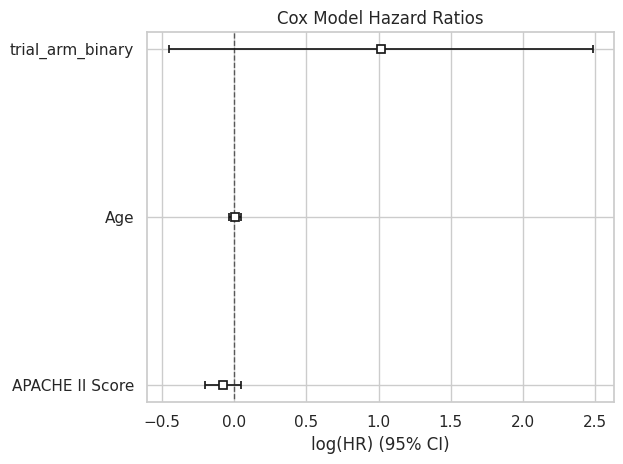

In [30]:
print("\nFitting Cox PH model...")

# select variables for model
cox_df = df[["time_to_event", "event", "trial_arm_binary", "Age", "APACHE II Score"]].dropna()

cox = CoxPHFitter()
cox.fit(cox_df, duration_col="time_to_event", event_col="event")

print("\nCox Model Summary:")
print(cox.summary)

cox.print_summary()  # detailed output
cox.plot()
plt.title("Cox Model Hazard Ratios")
plt.tight_layout()
plt.savefig("cox_hazard_ratios.png", dpi=300)
plt.show()


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...



/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.23358e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.02534e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.

🎉 Survival analysis complete.
Generated files:
 - km_curve.png
 - life_table.csv
 - logrank_test.txt
 - cox_hazard_ratios.png
 - Cox PH diagnostics shown above (save manually if needed)


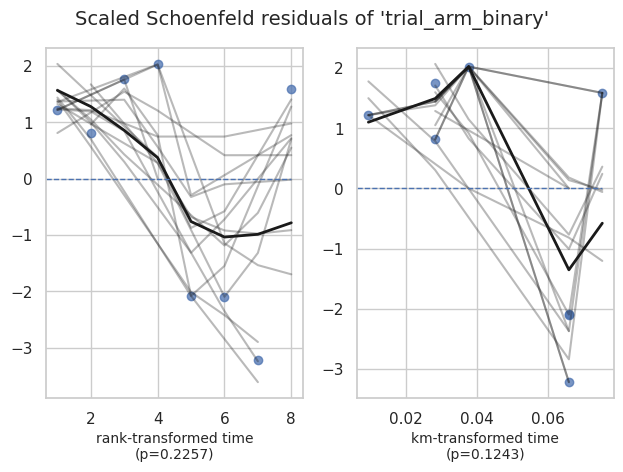

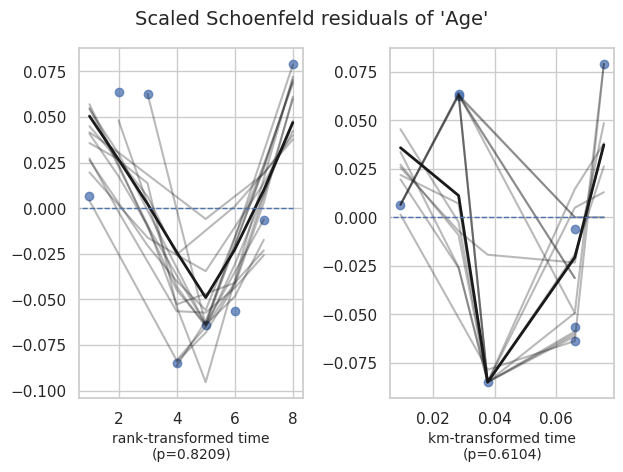

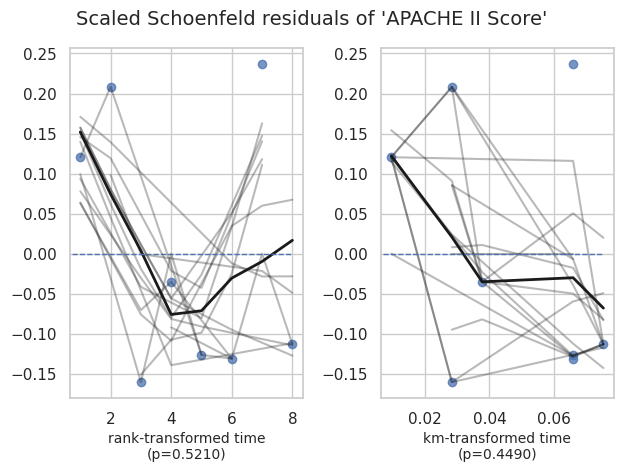

In [31]:
cox.check_assumptions(cox_df, p_value_threshold=0.05, show_plots=True)
print("\n🎉 Survival analysis complete.")
print("Generated files:")
print(" - km_curve.png")
print(" - life_table.csv")
print(" - logrank_test.txt")
print(" - cox_hazard_ratios.png")
print(" - Cox PH diagnostics shown above (save manually if needed)")


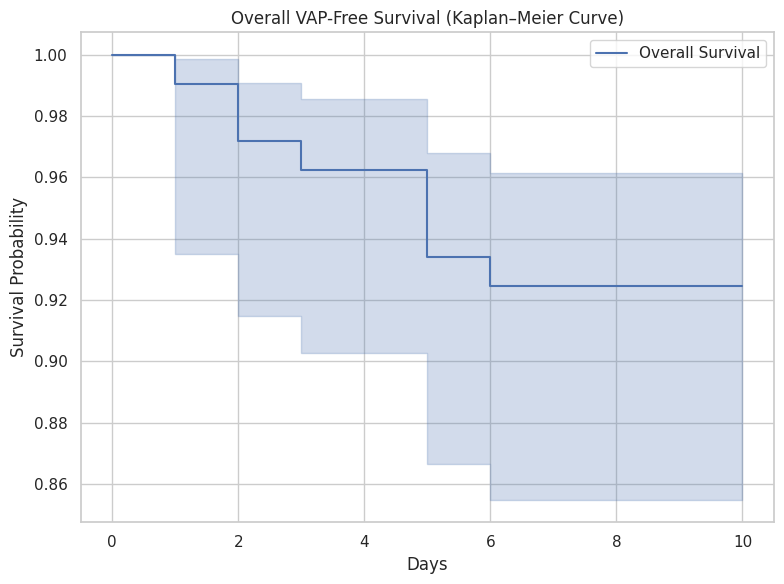

In [32]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 6))
kmf.fit(durations=df["time_to_event"], event_observed=df["event"], label="Overall Survival")
kmf.plot(ci_show=True)

plt.title("Overall VAP-Free Survival (Kaplan–Meier Curve)")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.tight_layout()
plt.savefig("km_overall.png", dpi=300)
plt.show()